# Fluid substitution using Gassmann
Necessary imports

In [2]:
import matplotlib.pyplot as plt
from copy import deepcopy
import utils.io as uio
from core.well import Project, Well
from core.minerals import MineralMix
from core.fluids import FluidMix
import rp.rp_core as rp

## Create a project
The project remembers where important information is stored, and controls the logging

In [3]:
wp = Project(
    name='FluidSub', 
    project_table='excels/project_table.xlsx')

Note that relative path names are allowed. The project table is a .xlsx file that contain which wells and well logs to load, where to find them, and important for fluid substitution; the fluids and minerals.

*Project* also take keywords:
- *working_dir* - the folder where the project is situated
- *log_to_stdout* - if True, logging information is sent to standard output, else to a text file

By default, none of these need to set, and it uses the install directory, toghether with example data and project table there


### Load wells
The *Wells table* sheet of the *project_table.xlsx* holds information about which wells and well logs to use.
<img src="images/Fluid substitution - wells.png" />
In this case, we only read in Well F, and the selected well logs that the las file *test_data/Well F.las* contains.

Wells are loaded using:

In [21]:
wells= wp.load_all_wells(block_name='FBlock')
w = wells['WELL_F']

0 WELL_F test_data/Well F.las


The *block_name* key word is used to group the logs of *Well F*, but is not necessary to specify.

### Load working intervals
The working intervals are used to define where the fluid substitution will take place, and are loaded through:

In [5]:
wis = uio.project_working_intervals(wp.project_table)

### Load fluids
The *Fluids* sheet of the *project_table.xlsx* holds information about the fluids that our fluid mixtures contains.
<img src="images/Fluid substitution - fluids.png" />

Column *A* to *D* contains name, bulk and shear modolus, and density (if column *E* is set to *User specified*). 
The name of a fluid must be unique.
The option to use Batzle and Wang method to calculate the elastic fluid properties is still not fully implemented, so the *Default* fluid in this example is ignored by the system right now.

The *Fluid mixtures* sheet uses the fluids defined above to determine how they are used in fluid substitution. 

<img src="images/Fluid substitution - fluidmixs.png" />

- *Column A*: **Substitution order** 
 - The first column determines if the fluid belongs to the *Initial* or *Final* fluids.
- *Column B*: **Well name**
 - Is the name of well, as defined in the *Wells table* sheet, this fluid is used in.  
- *Column C*: **Interval name**
 - name of the working interval this fluid is used
- *Column D*: **Fluid name**
 - The selected fluid, from *Fluids* sheet.:w
- *Column E*: **Volume fraction**
 - Column *E* determines which Volume fraction (saturation) to use for the fluid. Set it to the name of a well log (*SW* for the final Brine saturation in this example), or *complement* if the fluids takes up the remaining volume, or a number if a constant saturation is requested.

Load the fluids through

In [6]:
myfluids = FluidMix() 
myfluids.read_excel(wp.project_table)
print(myfluids)

WARNING Calculation of fluid properties is still not implemented, please use constant values
Fluid mixture: MyFluids
initial fluids:
 - Well WELL_F
  + Working interval SAND E
    brine
      K: 2.8, Mu: nan, Rho 1.1
      Calc. method: User specified
      Volume fraction: 1.0
final fluids:
 - Well WELL_F
  + Working interval SAND E
    oil
      K: 0.9, Mu: nan, Rho 0.8
      Calc. method: User specified
      Volume fraction: complement
    brine
      K: 2.8, Mu: nan, Rho 1.1
      Calc. method: User specified
      Volume fraction: sw



### Load minerals
Similarly to the fluids, the *Minerals* sheet of the *project_table.xlsx* holds information about the minerals used in the calculation of the mineral bulk modulus
<img src="images/Fluid substitution - Minerals.png" />
Column *A* to *D* contains name, bulk and shear modolus, and density of minerals. 

The *Mineral mixtures* sheet 
<img src="images/Fluid substitution - Mineralmixs.png" />

holds information about which minerals are present in individual intervals for each well, and their volume distribution.
Column *F* determines which Volume fraction (saturation) to use for the minerals. Set it to the name of a well log (*VCL* for the Shale in this example), or *complement* if the mineral takes up the remaining volume, or a number if a constant volume fraction is requested. 

Minerals for which no *Volume fraction* is specified are ignored by the system.

Load the minerals through

In [7]:
mymins = MineralMix() 
mymins.read_excel(wp.project_table)
print(mymins)

Mineral mixture: MyMinerals
 - Well WELL_F
  + Working interval SAND E
    quartz
      K: 36.6, Mu: 45.0, Rho 2.65
      Volume fraction: complement
    shale
      K: 11.4, Mu: 3.0, Rho 2.35
      Volume fraction: vcl



## Fluid substitution
Cut-offs are used to define sands, and we will restrict the fluid substitution to these

In [8]:
cutoffs = {'Volume': ['<', 0.5], 'Porosity': ['>', 0.1]}

### Mineral bulk modulus and porosity
Calculate the mineral bulk modulus using the Voigt-Reuss-Hill average of the volume fractions of the minerals defined in *mymins*. And extract the porosity

In [9]:
k0_dict = w.calc_vrh_bounds(mymins, param='k', wis=wis, method='Voigt-Reuss-Hill', block_name='FBlock')

por = w.block['FBlock'].logs['phie'].data

print('k0_dict is of type {}, with keywords {}'.format(type(k0_dict), list(k0_dict.keys())))

 Mineral k: quartz, volume frac: complement
 Mineral k: shale, volume frac: vcl
k0_dict is of type <class 'dict'>, with keywords ['SAND E']


C:\Users\marten\PycharmProjects\blixt_rp\rp\rp_core.py:469: RuntimeWarning: invalid value encountered in greater
  if (abs(sum(f) - 1.0) > 0.02).any():


**Note** that the bulk modulus above is calculated for the entire length of the well, but has a "keyword - value" pair (*SAND E* - bulk modulus) for each interval the minerals where defined in, in sheet *Mineral mixtures* sheet of the project table.

### Initial values
Calculate the density and bulk modulus of the initial fluids

In [10]:
rho_f1_dict = w.calc_vrh_bounds(myfluids.fluids['initial'], param='rho', wis=wis, method='Voigt', block_name='FBlock')
k_f1_dict = w.calc_vrh_bounds(myfluids.fluids['initial'], param='k', wis=wis, method='Reuss', block_name='FBlock')

 Fluid rho: brine, volume frac: 1.0
 Fluid k: brine, volume frac: 1.0


Similarly to the mineral bulk modulus, the fluids density and bulk modulus is calculated for the entire length of the well, but has a "keyword - value" pair for each working interval used in the definition of the initial (and final) fluids.

And extract the initial vp, vs and rho of the saturated rocks from the logs as *LogCurve* objects

In [11]:
v_p_1 = w.block['FBlock'].logs['vp_dry']  # a LogCurve object
v_s_1 = w.block['FBlock'].logs['vs_dry']
rho_1 = w.block['FBlock'].logs['rho_dry']

### Final values
The density and bulk modulus of the final fluids 

In [12]:
rho_f2_dict = w.calc_vrh_bounds(myfluids.fluids['final'], param='rho', wis=wis, method='Voigt', block_name='FBlock')
k_f2_dict = w.calc_vrh_bounds(myfluids.fluids['final'], param='k', wis=wis, method='Reuss', block_name='FBlock')

 Fluid rho: oil, volume frac: complement
 Fluid rho: brine, volume frac: sw
 Fluid k: oil, volume frac: complement
 Fluid k: brine, volume frac: sw


Then the final elastic properties can be calculated using Gassmann's.

As the fluids and minerals are defined in working intervals, we need to do the subsitution in each interval.

The cut-offs will also be applied in the results

In [22]:
tag = 'fs'  # tag the resulting logs after fluid substitution
for wi in list(rho_f1_dict.keys()):
    
    k_f1 = k_f1_dict[wi]
    rho_f1 = rho_f1_dict[wi]
    
    k_f2 = k_f2_dict[wi]
    rho_f2 = rho_f2_dict[wi]
    
    k0 = k0_dict[wi]
    
    # calculate the mask for the given cut-offs, and for the given working interval
    w.calc_mask(cutoffs, wis=wis, wi_name=wi, name='sand_mask')
    mask = w.block['FBlock'].masks['sand_mask'].data
    
    # Do the fluid substitution itself
    _v_p_2, _v_s_2, _rho_2, _k_2 = rp.gassmann_vel(
        v_p_1.data, v_s_1.data, rho_1.data, k_f1, rho_f1, k_f2, rho_f2, k0, por)
    
    # copy the inital LogCurves, so that we can use the copies to hold the fluid substituted values
    v_p_2 = deepcopy(v_p_1)
    v_s_2 = deepcopy(v_s_1)
    rho_2 = deepcopy(rho_1)
    
    # Add the fluid substituted results to the new LogCurve objects
    for xx, yy in zip([v_p_2, v_s_2, rho_2], [_v_p_2, _v_s_2, _rho_2]):
        orig_name = deepcopy(xx.name)
        xx.name += '_{}_{}'.format(wi.lower().replace(' ','_'), tag.lower())
        xx.header.name += '_{}_{}'.format(wi.lower().replace(' ','_'), tag.lower())
        xx.header.desc = 'Fluid substituted {}'.format(orig_name) 
        mod_history = 'Calculated using Gassmann fluid substitution using following\n'
        mod_history += 'Mineral mixtures: {}\n'.format(mymins.print_minerals(w.well, wi))
        mod_history += 'Initial fluids: {}\n'.format(
            myfluids.print_fluids('initial', w.well, wi))
        mod_history += 'Final fluids: {}\n'.format(
            myfluids.print_fluids('final', w.well, wi))
        xx.header.modification_history = mod_history 
        xx.data[mask] = yy[mask]
        w.block['FBlock'].add_log_curve(xx)

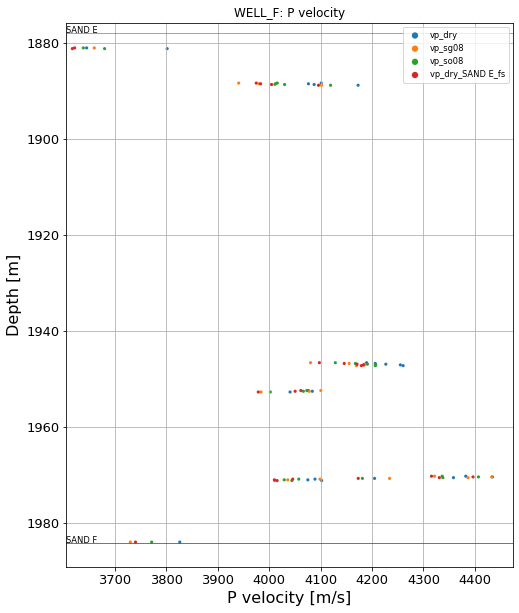

In [23]:
w.depth_plot('P velocity', wis=wis, mask=mask)

Save the well as a las file

In [20]:
uio.write_las('results_folder/test.las', w.header, w.block['FBlock'].header, w.block['FBlock'].logs)

In [16]:
w.block['FBlock'].logs['vp_dry_sand e_fs'].header

                name: vp_dry_sand e_fs
                well: WELL_F
       creation_info: Created by marten, at DESKTOP-7JFC02N, on 2020-04-17T08:03:37.873822, using version XXX
       creation_date: 2020-04-17T08:03:37.873822
       orig_filename: test_data/Well F.las
   modification_date: 2020-04-17T08:03:51.461951
modification_history: Calculated using Gassmann fluid substitution
            log_type: P velocity
            api_code: None
                unit: m/s
                desc: Fluid subsituted using following
 Mineral mixtures: Mineral mixture: WELL_F, SAND E, MyMinerals
    quartz
      K: 36.6, Mu: 45.0, Rho 2.65
      Volume fraction: complement
    shale
      K: 11.4, Mu: 3.0, Rho 2.35
      Volume fraction: vcl

Initial fluids: Fluid mixture: initial, WELL_F, SAND E, MyFluids
    brine
      K: 2.8, Mu: nan, Rho 1.1
      Volume fraction: 1.0

Final fluids: Fluid mixture: final, WELL_F, SAND E, MyFluids
    oil
      K: 0.9, Mu: nan, Rho 0.8
      Volume fraction: com